<a href="https://colab.research.google.com/github/narae12/aiffel/blob/main/Olist_Delivery_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÌÜµÌï© Î∞∞ÏÜ° Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù

## Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï¥àÍ∏∞ ÏÑ§Ï†ï

In [ ]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import kagglehub
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú_ÎÇòÎûò
# order_items = pd.read_csv('/content/drive/MyDrive/ÏïÑÏù¥Ìé†/data/olist_order_items_dataset.csv')
# products = pd.read_csv('/content/drive/MyDrive/ÏïÑÏù¥Ìé†/data/olist_products_dataset.csv')
# orders = pd.read_csv('/content/drive/MyDrive/ÏïÑÏù¥Ìé†/data/olist_orders_dataset.csv')
# customers = pd.read_csv("/content/drive/MyDrive/ÏïÑÏù¥Ìé†/data/olist_customers_dataset.csv")
# sellers = pd.read_csv("/content/drive/MyDrive/ÏïÑÏù¥Ìé†/data/olist_sellers_dataset.csv")

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú_ÏÜåÌù¨

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# CSV ÌååÏùºÎ°ú ÏùΩÍ∏∞
# Ï†úÌíà Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞
orders = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(path, 'olist_products_dataset.csv'))
sellers = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))
customers = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42.6M/42.6M [00:01<00:00, 27.2MB/s]

Extracting files...


## Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© Î∞è Ï†ÑÏ≤òÎ¶¨

### Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©

In [ ]:
# Î≥ëÌï© Îã®Í≥Ñ
merge_df = order_items.merge(products, on='product_id', how='left')
full_df = merge_df.merge(orders, on='order_id', how='left')
full_df = full_df.merge(customers[['customer_id', 'customer_city']], on='customer_id', how='left')
full_df = full_df.merge(sellers[['seller_id', 'seller_city']], on='seller_id', how='left')

### ÎÇ†Ïßú Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò Î∞è Ï∂îÍ∞Ä Ï†ÑÏ≤òÎ¶¨

In [ ]:
# ÎÇ†Ïßú Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò
full_df['order_delivered_customer_date'] = pd.to_datetime(full_df['order_delivered_customer_date'])
full_df['order_delivered_carrier_date'] = pd.to_datetime(full_df['order_delivered_carrier_date'])
full_df['order_estimated_delivery_date'] = pd.to_datetime(full_df['order_estimated_delivery_date'])

# Î∞∞ÏÜ° ÏãúÍ∞Ñ Í≥ÑÏÇ∞
full_df['actual_shipping_time'] = (full_df['order_delivered_customer_date'] - full_df['order_delivered_carrier_date']).dt.days
# Î∞∞ÏÜ° ÏßÄÏó∞ Ïó¨Î∂Ä (ÏòàÏ∏° Î∞∞ÏÜ° ÎÇ†ÏßúÎ≥¥Îã§ Îä¶Í≤å ÎèÑÏ∞©ÌïòÎ©¥ ÏßÄÏó∞)
full_df['delivery_delay'] = (full_df['order_delivered_customer_date'] - full_df['order_estimated_delivery_date']).dt.days # ÏßÄÏó∞ Ïó¨Î∂Ä (True / False)
# full_df ÏÉùÏÑ± (merge_dfÏôÄ orders Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©)
full_df['delayed'] = full_df['delivery_delay'] > 0

In [ ]:
full_df.shape

(112650, 27)

In [ ]:
full_df.isnull().sum() #Îß§Ïö∞ Ï§ëÏöîÌïú Î≥ÄÏàòÎì§Ïù¥ÎØÄÎ°ú Í≤∞Ï∏°ÏπòÎäî drop

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_city                       0
seller_city                         0
actual_shipping_time             2455
delivery_delay                   2454
delayed                             0
dtype: int64

### Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨

In [ ]:
# Í≤∞Ï∏°Í∞í Ï†úÍ±∞
full_df = full_df.dropna(subset=['actual_shipping_time', 'delivery_delay'])

In [ ]:
full_df.shape #ÏïΩ 2ÌçºÏÑºÌä∏ Ï†úÍ±∞Î°ú Î¨∏Ï†ú ÏóÜÏùÑÍ≤ÉÏù¥Îùº ÌåêÎã®

(110195, 27)

### Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110195 entries, 0 to 112649
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110195 non-null  object        
 1   order_item_id                  110195 non-null  int64         
 2   product_id                     110195 non-null  object        
 3   seller_id                      110195 non-null  object        
 4   shipping_limit_date            110195 non-null  object        
 5   price                          110195 non-null  float64       
 6   freight_value                  110195 non-null  float64       
 7   product_category_name          108658 non-null  object        
 8   product_name_lenght            108658 non-null  float64       
 9   product_description_lenght     108658 non-null  float64       
 10  product_photos_qty             108658 non-null  float64       
 11  produ

## EDA (ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù)

### Î¨¥Í≤åÏôÄ Î∞∞ÏÜ° ÏãúÍ∞Ñ ÎπÑÍµê (Î¨¥Í±∞Ïö¥ Ï†úÌíà vs Í∞ÄÎ≤ºÏö¥ Ï†úÌíà Î∞∞ÏÜ° Ï∞®Ïù¥ ÌôïÏù∏ÌïòÍ∏∞)

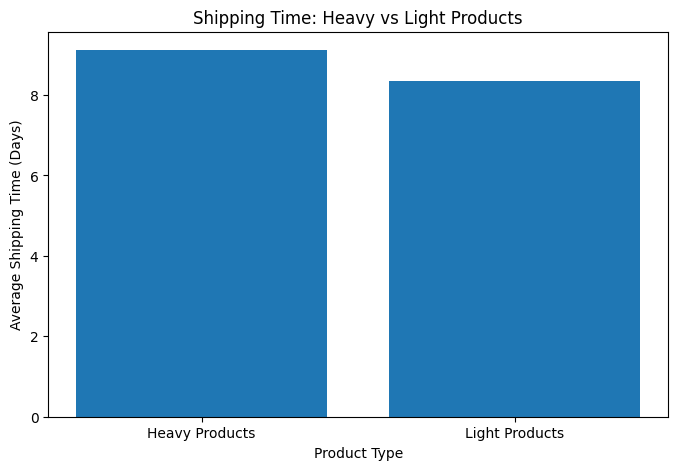

In [ ]:
# Ï†úÌíà Î¨¥Í≤å Í∏∞Ï§Ä Í∑∏Î£π ÎÇòÎàÑÍ∏∞(Î¨¥Í±∞Ïö¥ Ï†úÌíà: ÏÉÅÏúÑ 50%, Í∞ÄÎ≤ºÏö¥ Ï†úÌíà: ÌïòÏúÑ 50%)
median_weight = full_df["product_weight_g"].median()
heavy_products = full_df[full_df["product_weight_g"] >= median_weight]
light_products = full_df[full_df["product_weight_g"] < median_weight]

# Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Î∞∞ÏÜ° ÏãúÍ∞Ñ Í≥ÑÏÇ∞
avg_shipping_time_heavy = heavy_products["actual_shipping_time"].mean()
avg_shipping_time_light = light_products["actual_shipping_time"].mean()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.bar(["Heavy Products", "Light Products"], [avg_shipping_time_heavy, avg_shipping_time_light])
plt.xlabel("Product Type")
plt.ylabel("Average Shipping Time (Days)")
plt.title("Shipping Time: Heavy vs Light Products")
plt.show()

### Î∂ÄÌîºÏôÄ Î∞∞ÏÜ° ÏãúÍ∞Ñ ÎπÑÍµê (ÌÅ¨Í∏∞Í∞Ä ÌÅ∞ Ï†úÌíà ÏûëÏùÄ Ï†úÌíà ÌèâÍ∑† Î∞∞ÏÜ° ÏãúÍ∞Ñ ÎπÑÍµêÌïòÍ∏∞)

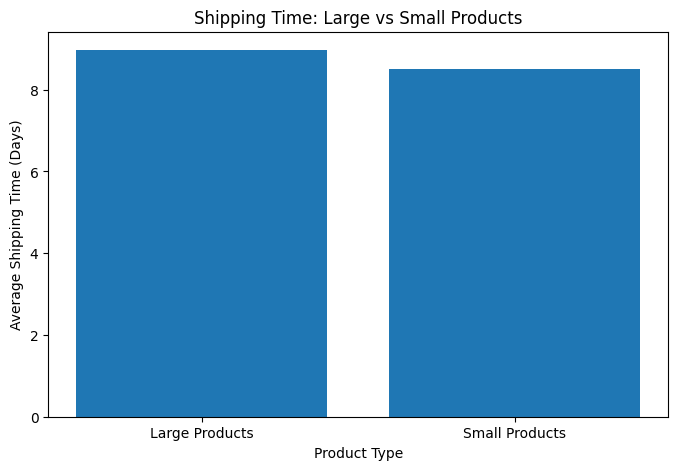

In [ ]:
# Ï†úÌíà Î∂ÄÌîº Í≥ÑÏÇ∞
full_df["product_volume_cm3"] = (
    full_df["product_length_cm"] * full_df["product_width_cm"] * full_df["product_height_cm"]
)

# Î∂ÄÌîº Í∏∞Ï§Ä Í∑∏Î£π ÎÇòÎàÑÍ∏∞
median_volume = full_df["product_volume_cm3"].median()
large_products = full_df[full_df["product_volume_cm3"] >= median_volume]
small_products = full_df[full_df["product_volume_cm3"] < median_volume]

# ÌèâÍ∑† Î∞∞ÏÜ° ÏãúÍ∞Ñ Í≥ÑÏÇ∞
avg_shipping_time_large = large_products["actual_shipping_time"].mean()
avg_shipping_time_small = small_products["actual_shipping_time"].mean()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.bar(["Large Products", "Small Products"], [avg_shipping_time_large, avg_shipping_time_small])
plt.xlabel("Product Type")
plt.ylabel("Average Shipping Time (Days)")
plt.title("Shipping Time: Large vs Small Products")
plt.show()

### Î∞∞ÏÜ° ÏßÄÏó∞ Î∂ÑÏÑù (Í∞ÄÏû• Î∞∞ÏÜ°Ïù¥ Îä¶Ïñ¥ÏßÄÎäî Ï†úÌíà Ï∞æÏïÑÎ≥¥Í∏∞)

In [ ]:
# ÏßÄÏó∞Îêú Ï£ºÎ¨∏ ÌïÑÌÑ∞ÎßÅ
delayed_orders = full_df[full_df["delayed"]]

# Ï†úÌíàÎ≥Ñ ÏßÄÏó∞ ÌöüÏàò ÏßëÍ≥Ñ
delayed_products_count = delayed_orders.groupby("product_id").size().reset_index(name="delay_count")

# ÏßÄÏó∞ ÌöüÏàò ÏÉÅÏúÑ 10Í∞ú Ï†úÌíà
top_delayed_products = delayed_products_count.sort_values(by="delay_count", ascending=False).head(10)

# Ï†úÌíà Ïπ¥ÌÖåÍ≥†Î¶¨ Ï∂îÍ∞Ä
top_delayed_products = pd.merge(top_delayed_products, products[["product_id", "product_category_name"]], on="product_id", how="left")

# Í≤∞Í≥º ÌëúÏãú
print(top_delayed_products)

                         product_id  delay_count   product_category_name
0  422879e10f46682990de24d770e7f83d           47      ferramentas_jardim
1  aca2eb7d00ea1a7b8ebd4e68314663af           42        moveis_decoracao
2  3fbc0ef745950c7932d5f2a446189725           39            beleza_saude
3  389d119b48cf3043d311335e499d9c6b           30      ferramentas_jardim
4  368c6c730842d78016ad823897a372db           29      ferramentas_jardim
5  99a4788cb24856965c36a24e339b6058           29         cama_mesa_banho
6  53759a2ecddad2bb87a079a1f1519f73           29      ferramentas_jardim
7  bb50f2e236e5eea0100680137654686c           28            beleza_saude
8  19c91ef95d509ea33eda93495c4d3481           28            beleza_saude
9  e53e557d5a159f5aa2c5e995dfdf244b           25  informatica_acessorios


### Ïôú Îä¶Ïñ¥Ï°åÎäîÏßÄ Î∂ÑÏÑùÌï¥ Î≥¥Í∏∞

In [ ]:
top_delayed_products

product_id  delay_count   product_category_name
0  422879e10f46682990de24d770e7f83d           47      ferramentas_jardim
1  aca2eb7d00ea1a7b8ebd4e68314663af           42        moveis_decoracao
2  3fbc0ef745950c7932d5f2a446189725           39            beleza_saude
3  389d119b48cf3043d311335e499d9c6b           30      ferramentas_jardim
4  368c6c730842d78016ad823897a372db           29      ferramentas_jardim
5  99a4788cb24856965c36a24e339b6058           29         cama_mesa_banho
6  53759a2ecddad2bb87a079a1f1519f73           29      ferramentas_jardim
7  bb50f2e236e5eea0100680137654686c           28            beleza_saude
8  19c91ef95d509ea33eda93495c4d3481           28            beleza_saude
9  e53e557d5a159f5aa2c5e995dfdf244b           25  informatica_acessorios

In [ ]:
top_delayed_weights = products["product_weight_g"].mean()
top_delayed_volumes = ( products["product_length_cm"] *
                        products["product_width_cm"] *
                        products["product_height_cm"]).mean()

# 2Ô∏è‚É£ ÏùºÎ∞ò Ï†úÌíà(ÏßÄÏó∞ÎêòÏßÄ ÏïäÏùÄ Ï†úÌíà)Îì§Ïùò Î¨¥Í≤å & Î∂ÄÌîº ÌèâÍ∑† Í≥ÑÏÇ∞
normal_products = full_df[~full_df["product_id"].isin(top_delayed_products["product_id"])]
normal_weights = normal_products["product_weight_g"].mean()
normal_volumes = (normal_products["product_length_cm"] *
                  normal_products["product_width_cm"] *
                  normal_products["product_height_cm"]).mean()

Text(0.5, 1.0, 'Comparison of Average Volume')

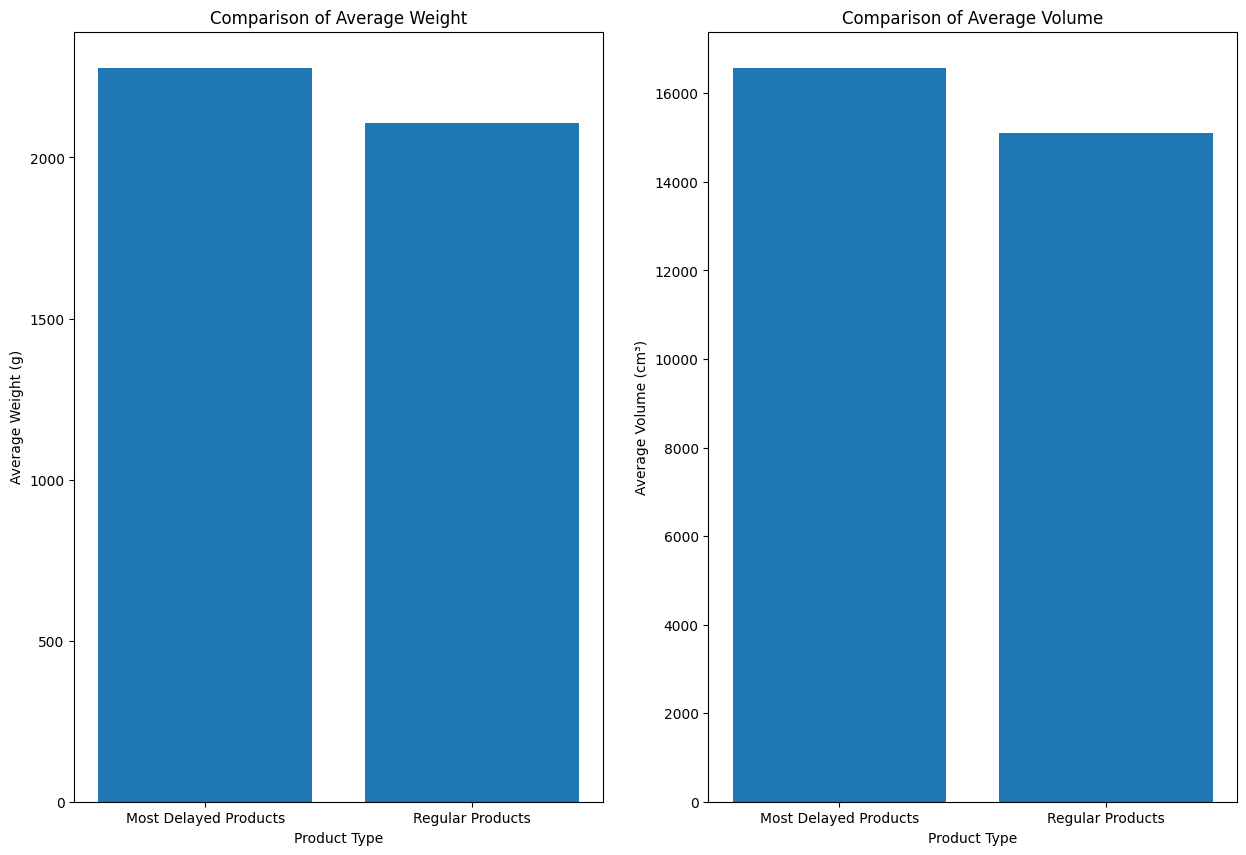

In [ ]:
# üìä ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 10))

# Î¨¥Í≤å ÎπÑÍµê
plt.subplot(1, 2, 1)
plt.bar(["Most Delayed Products", "Regular Products"], [top_delayed_weights, normal_weights])
plt.xlabel("Product Type")
plt.ylabel("Average Weight (g)")
plt.title("Comparison of Average Weight")


# Î∂ÄÌîº ÎπÑÍµê
plt.subplot(1, 2, 2)
plt.bar(["Most Delayed Products", "Regular Products"], [top_delayed_volumes, normal_volumes])
plt.xlabel("Product Type")
plt.ylabel("Average Volume (cm¬≥)")
plt.title("Comparison of Average Volume")

### Í±∞Î¶¨Ïóê Îî∞Î•∏ Î∞∞ÏÜ°ÏßÄÏó∞ Î∂ÑÏÑùÌï¥Î≥¥Í∏∞

In [ ]:
#Ïö∞Ìé∏ Î≤àÌò∏Î°ú Î∂ÑÏÑù Ìï¥Î≥¥Î†§ ÌñàÎäîÎç∞ Ïö∞Ìé∏Î≤àÌò∏ ÎπÑÏä∑ÌïúÍ±∏Î°ú Î∂ÑÏÑùÌïòÍ∏∞ÏóêÎäî ÎÑàÎ¨¥ Í∑ºÍ±∞ ÏóÜÏñ¥ÏÑú
#‚úÖ ÏÉàÎ°úÏö¥ Î∂ÑÏÑù Î∞©Î≤ï (ÎèÑÏãú Í∏∞Î∞ò)
# Step 1: Í≥†Í∞ùÍ≥º ÌåêÎß§ÏûêÏùò ÎèÑÏãú Ï†ïÎ≥¥ Ï∂îÍ∞Ä
# Step 2: Í∞ôÏùÄ ÎèÑÏãúÏóê ÏûàÎäî Í≤ΩÏö∞ÏôÄ Îã§Î•∏ ÎèÑÏãúÏóê ÏûàÎäî Í≤ΩÏö∞ ÎÇòÎàÑÍ∏∞
# Step 3: Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Î∞∞ÏÜ° ÏßÄÏó∞ ÏãúÍ∞Ñ ÎπÑÍµê

In [ ]:
# üöÄ Í∞ôÏùÄ ÎèÑÏãúÏóê ÏûàÎäî Í≤ΩÏö∞ÏôÄ Îã§Î•∏ ÎèÑÏãúÏóê ÏûàÎäî Í≤ΩÏö∞ Íµ¨Î∂Ñ
full_df['same_city'] = full_df['customer_city'] == full_df['seller_city']
# Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Î∞∞ÏÜ° ÏßÄÏó∞ ÏãúÍ∞Ñ Í≥ÑÏÇ∞
city_delay = full_df.groupby('same_city')['delivery_delay'].mean().reset_index()
city_delay['same_city'] = city_delay['same_city'].map({True: 'Same City', False: 'Different City'})
city_delay

# ÏòàÏÉÅ Î∞∞ÏÜ°ÏùºÎ≥¥Îã§ Îçî Îπ®Î¶¨ ÎèÑÏ∞©ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏßÄÎßå Îã§Î•∏ Í∞íÏù¥Îçî Ïò§Îûò Í±∏Î¶º

same_city  delivery_delay
0  Different City      -12.172794
1       Same City       -9.430818

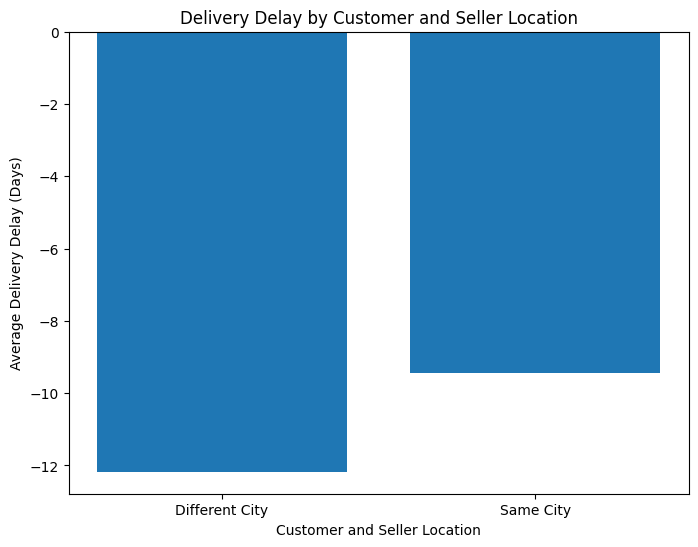

In [ ]:
# üìä ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
plt.bar(city_delay['same_city'], city_delay['delivery_delay'])
plt.xlabel("Customer and Seller Location")
plt.ylabel("Average Delivery Delay (Days)")
plt.title("Delivery Delay by Customer and Seller Location")
plt.show()


#ÎèÑÏãúÎ≥Ñ Î∞∞ÏÜ°Í∏∞Í∞Ñ ÌôïÏù∏ÌïòÍ∏∞

In [ ]:
# ÎèÑÏãúÎ≥Ñ ÌèâÍ∑† Î∞∞ÏÜ° ÏßÄÏó∞ ÏãúÍ∞Ñ Í≥ÑÏÇ∞
city_delay = full_df.groupby('customer_city')['delivery_delay'].mean().reset_index()


In [ ]:
# Ï£ºÎ¨∏Ïù¥ ÎßéÏùÄ ÏÉÅÏúÑ 10Í∞ú ÎèÑÏãúÎßå Ï∂îÏ∂ú (Ï£ºÎ¨∏ ÏàòÍ∞Ä ÎßéÏùÄ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨)
top_cities = full_df['customer_city'].value_counts().head(10).index
city_delay = city_delay[city_delay['customer_city'].isin(top_cities)]

In [ ]:
# ÎèÑÏãúÎ≥Ñ ÌèâÍ∑† Î∞∞ÏÜ° ÏßÄÏó∞ ÏãúÍ∞ÑÏùÑ ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
city_delay_sorted_desc = city_delay.sort_values(by="delivery_delay", ascending=False)

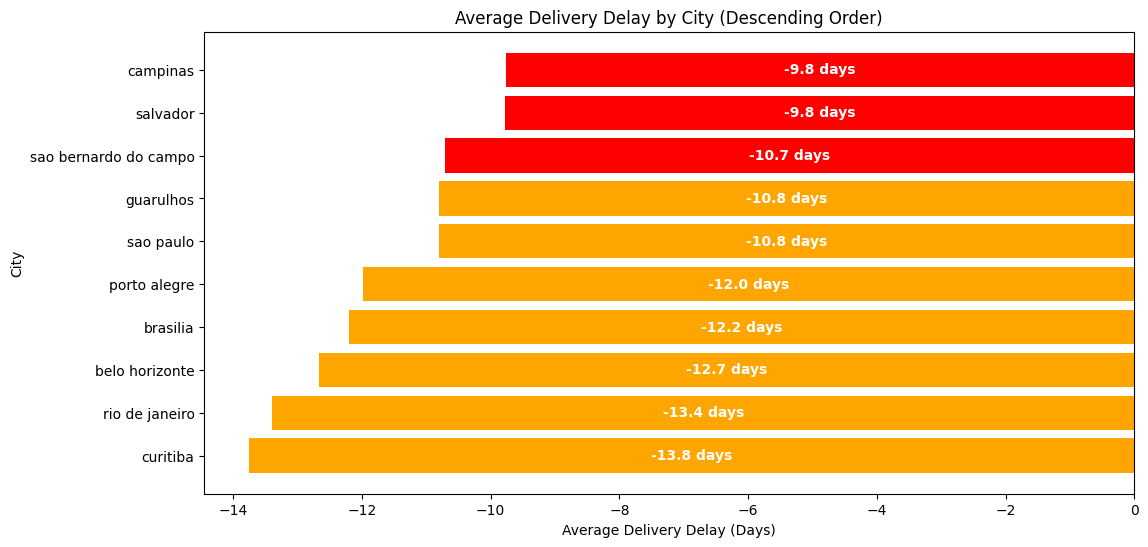

In [ ]:
# ÏãúÍ∞ÅÌôî ÏßÑÌñâ (ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨, ÏÉÅÏúÑ 3Í∞ú ÎèÑÏãú Í∞ïÏ°∞)
plt.figure(figsize=(12, 6))

# ÎßâÎåÄ ÏÉâÏÉÅ ÏÑ§Ï†ï (ÏÉÅÏúÑ 3Í∞ú ÎèÑÏãúÎßå Îπ®Í∞ÑÏÉâ)
colors = ['red' if i < 3 else 'orange' for i in range(len(city_delay_sorted_desc))]

bars = plt.barh(city_delay_sorted_desc['customer_city'], city_delay_sorted_desc['delivery_delay'], color=colors)

# Í∞Å ÎßâÎåÄ ÏïàÏóê ÌèâÍ∑† ÏßÄÏó∞ ÏùºÏàò ÌëúÏãú (ÎßâÎåÄ ÎÇ¥Î∂ÄÏóê Í∏ÄÏî® ÎÑ£Í∏∞)
for bar, delay in zip(bars, city_delay_sorted_desc['delivery_delay']):
    plt.text(bar.get_width() / 2,  # x ÏúÑÏπò (ÎßâÎåÄÏùò Ï§ëÍ∞Ñ)
             bar.get_y() + bar.get_height() / 2,  # y ÏúÑÏπò (ÎßâÎåÄÏùò Ï§ëÏïô)
             f"{delay:.1f} days",  # ÌëúÏãúÌï† ÌÖçÏä§Ìä∏ (ÏÜåÏàòÏ†ê 1ÏûêÎ¶¨ÍπåÏßÄ)
             va='center', ha='center', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Average Delivery Delay (Days)")
plt.ylabel("City")
plt.title("Average Delivery Delay by City (Descending Order)")
plt.gca().invert_yaxis()



## Î™®Îç∏ÎßÅ Î∞è ÌèâÍ∞Ä

### Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

In [ ]:
full_df.shape

(110195, 29)

In [ ]:
# ÌäπÏÑ± ÏÑ†ÌÉù
feature_columns = [
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'freight_value'
]

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Î∞è Ïä§ÏºÄÏùºÎßÅ
X = full_df[feature_columns]
y = full_df['delayed'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

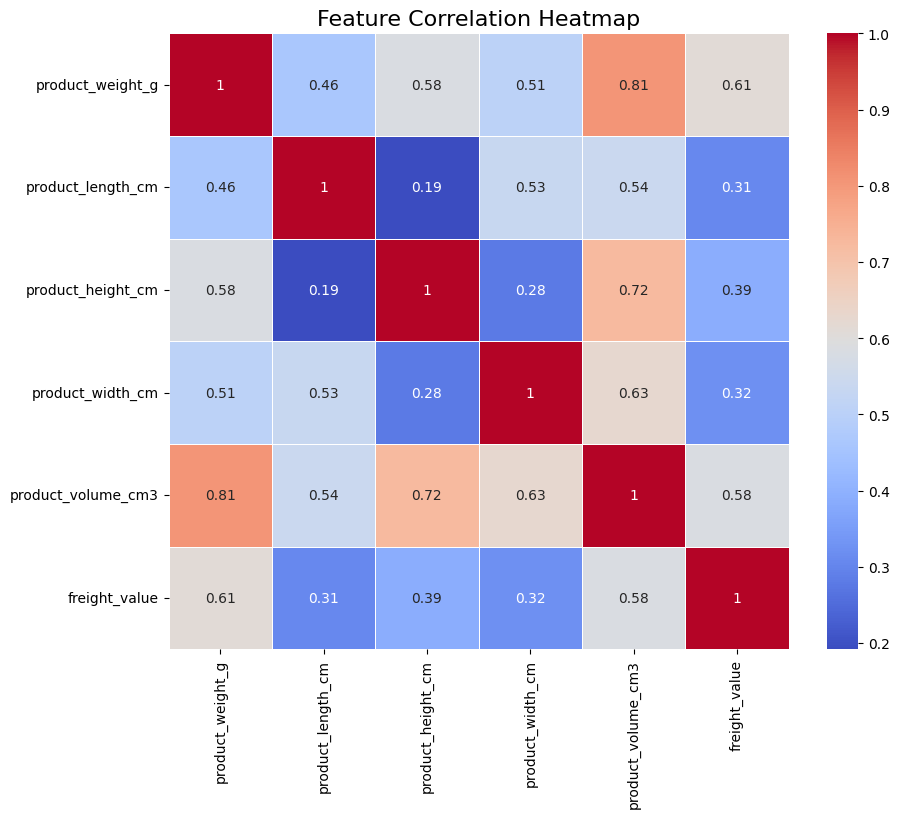

In [ ]:
corr_matrix = full_df[[
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'freight_value'
]].corr()

# ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

###  Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä

In [ ]:
# Step 1: Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨ (ÌèâÍ∑†Í∞íÏúºÎ°ú ÎåÄÏ≤¥)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)  # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
X_test_imputed = imputer.transform(X_test_scaled)       # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨

# Step 2: ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨ (SMOTE Ï†ÅÏö©)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Step 3: Ïä§ÏºÄÏùºÎßÅ
scaler = StandardScaler()
X_train_scaled_final = scaler.fit_transform(X_train_resampled)
X_test_scaled_final = scaler.transform(X_test_imputed)

# Step 4: Î™®Îç∏ Ï†ïÏùò
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
}

# Step 5: Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
results = {}

for name, model in models.items():
    # Î™®Îç∏ ÌïôÏäµ
    model.fit(X_train_scaled_final, y_train_resampled)

    # ÏòàÏ∏° Í≤∞Í≥º
    y_pred = model.predict(X_test_scaled_final)
    y_pred_proba = model.predict_proba(X_test_scaled_final)[:, 1]  # ROC-AUC Í≥ÑÏÇ∞Ïö© ÌôïÎ•†Í∞í

    # ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
    classification = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    confusion = confusion_matrix(y_test, y_pred)

    # Í≤∞Í≥º Ï†ÄÏû•
    results[name] = {
        'classification_report': classification,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion
    }

    # Í≤∞Í≥º Ï∂úÎ†•
    print(f"\n{name} Results:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion}")



Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20535
           1       0.20      0.23      0.21      1504

    accuracy                           0.89     22039
   macro avg       0.57      0.58      0.58     22039
weighted avg       0.89      0.89      0.89     22039

ROC-AUC: 0.6515
Confusion Matrix:
[[19209  1326]
 [ 1165   339]]

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     20535
           1       0.09      0.37      0.15      1504

    accuracy                           0.70     22039
   macro avg       0.52      0.55      0.48     22039
weighted avg       0.88      0.70      0.78     22039

ROC-AUC: 0.5845
Confusion Matrix:
[[14960  5575]
 [  943   561]]

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0

In [ ]:
# # PCA Î≤ÑÏ†Ñ

# from sklearn.decomposition import PCA
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# # Step 1: Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨ (ÌèâÍ∑†Í∞íÏúºÎ°ú ÎåÄÏ≤¥)
# imputer = SimpleImputer(strategy='mean')
# X_train_imputed = imputer.fit_transform(X_train_scaled)  # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
# X_test_imputed = imputer.transform(X_test_scaled)       # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨

# # Step 2: PCA Ï†ÅÏö© (ÏÑ§Î™Ö Î∂ÑÏÇ∞ ÎπÑÏú®ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ï∞®Ïõê Ï∂ïÏÜå, Ïòà: 95% Ïù¥ÏÉÅ Ïú†ÏßÄ)
# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_imputed)
# X_test_pca = pca.transform(X_test_imputed)

# # Step 3: ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨ (SMOTE Ï†ÅÏö©)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# # Step 4: Ïä§ÏºÄÏùºÎßÅ
# scaler = StandardScaler()
# X_train_scaled_final = scaler.fit_transform(X_train_resampled)
# X_test_scaled_final = scaler.transform(X_test_pca)

# # Step 5: Î™®Îç∏ Ï†ïÏùò
# models = {
#     'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
#     'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
#     'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
# }

# # Step 6: Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
# results = {}

# for name, model in models.items():
#     # Î™®Îç∏ ÌïôÏäµ
#     model.fit(X_train_scaled_final, y_train_resampled)

#     # ÏòàÏ∏° Í≤∞Í≥º
#     y_pred = model.predict(X_test_scaled_final)
#     y_pred_proba = model.predict_proba(X_test_scaled_final)[:, 1]  # ROC-AUC Í≥ÑÏÇ∞Ïö© ÌôïÎ•†Í∞í

#     # ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
#     classification = classification_report(y_test, y_pred, output_dict=True)
#     roc_auc = roc_auc_score(y_test, y_pred_proba)
#     confusion = confusion_matrix(y_test, y_pred)

#     # Í≤∞Í≥º Ï†ÄÏû•
#     results[name] = {
#         'classification_report': classification,
#         'roc_auc': roc_auc,
#         'confusion_matrix': confusion
#     }

#     # Í≤∞Í≥º Ï∂úÎ†•
#     print(f"\n{name} Results:")
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))
#     print(f"ROC-AUC: {roc_auc:.4f}")
#     print(f"Confusion Matrix:\n{confusion}")


Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     20535
           1       0.18      0.27      0.21      1504

    accuracy                           0.86     22039
   macro avg       0.56      0.59      0.57     22039
weighted avg       0.89      0.86      0.88     22039

ROC-AUC: 0.6567
Confusion Matrix:
[[18615  1920]
 [ 1096   408]]

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     20535
           1       0.09      0.37      0.14      1504

    accuracy                           0.70     22039
   macro avg       0.51      0.55      0.48     22039
weighted avg       0.88      0.70      0.77     22039

ROC-AUC: 0.5841
Confusion Matrix:
[[14877  5658]
 [  948   556]]

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0

### Í≤∞Í≥º ÏãúÍ∞ÅÌôî

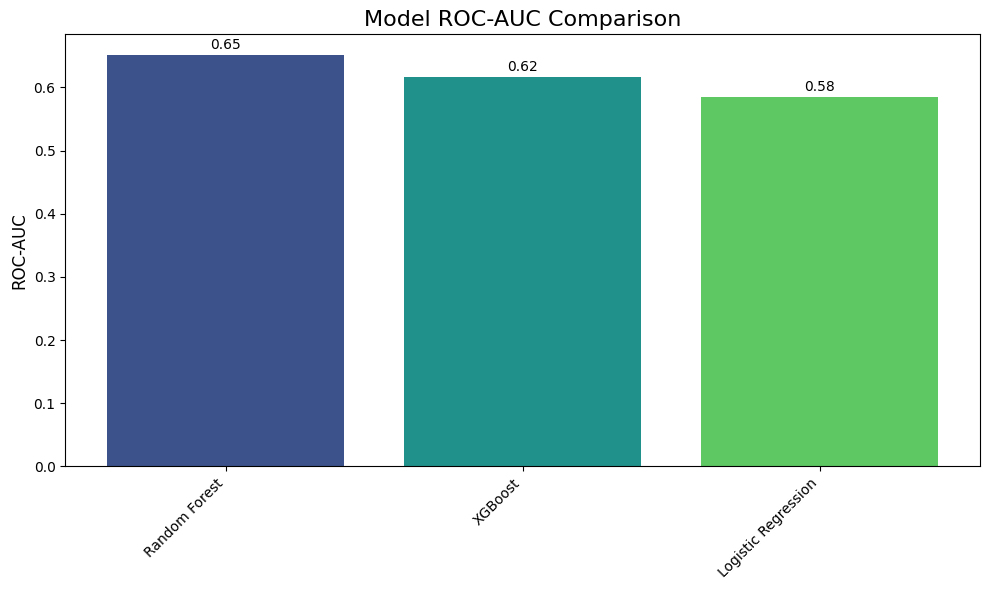

In [ ]:
# ROC-AUC ÎπÑÍµê
sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['roc_auc'], reverse=True))  # ROC-AUC Í∏∞Ï§Ä Ï†ïÎ†¨

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(sorted_results))  # ÏÉâÏÉÅ ÌåîÎ†àÌä∏
plt.bar(sorted_results.keys(), [res['roc_auc'] for res in sorted_results.values()], color=colors)

# Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è Ï∂ï ÏÑ§Ï†ï
plt.title("Model ROC-AUC Comparison", fontsize=16)
plt.ylabel("ROC-AUC", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Í∞Å Î∞î ÏúÑÏóê ROC-AUC Í∞í ÌëúÏãú
for i, v in enumerate([res['roc_auc'] for res in sorted_results.values()]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
